## Reward Signals
Data Collected at Rutgers University by David Smith

### Variable Key

#### Raw Data Names
- soc_win - affective feedback in a trial. 0 lose and 1 is win 
- partner - 0 is nonsocial and 1  is social
- deckchoice - 0 or 1 based on participant choice of option
- lapse1 and lapse2 - participant did not respond in either decision phase

#### Derived Data Names
- aff_feedback_curr - renamed soc_win
- aff_feedback_prev - aff_feedback_curr shifted by one trial to reflect t -1
- is_social - renamed partner
- choice - renamed deckchoice
- prev_partner - partner on previous trial
- prev_aff_fb - affective feedback in the previous trial, 0 is lose and 1 is win
- star_points - known value of option 1 
- pentagon_points - known value of option 2 
- diff_point - difference between the two options most recent point value

In [1]:
import pandas as pd
import glob
import numpy as np
from scipy.io import loadmat
import seaborn as sns
import itertools
from sklearn.linear_model import LogisticRegression

In [2]:
col_list = ['Npoints', 
            'lapse1',
            'lapse2', 
            'deckchoice', 
            'RT1', 
            'RT2', 
            'choice_onset', 
            'press1_onset', 
            'info_onset', 
            'partner_onset', 
            'press2_onset', 
            'aff_onset', 
            'fix1_list', 
            'fix2_list', 
            'fix3_list', 
            'fix4_list', 
            'soc_win', 
            'block', 
            'duration', 
            'frequency', 
            'stimaff', 
            'stiminf', 
            'point_total', 
            'word', 
            'rating', 
            'is_catch', 
            'partner', 
            'highval_count']

file_list = glob.glob('data/10*/*feedback_[1-4].mat')

sub_count = 26

per_subject_files = np.array_split(file_list[2:], sub_count)

for subject in per_subject_files:

    df_list = []
    for run in subject:
        df = pd.DataFrame([[row.flat[0] for row in line] for line in loadmat(run)['data'][0]], columns=col_list)
        df_list.append(df)
    
    df = pd.concat(df_list).reset_index()
    

    df = df.drop(df[(df['lapse1'] == 1)].index)
    df = df.drop(df[(df['lapse2'] == 1)].index)
    df = df.drop(df[(df['deckchoice'] == 11)].index)
    df = df.drop(df[(df['deckchoice'] == 22)].index)
    df = df.reset_index()
    
    known_val1 = []
    known_val2 = []
    
    for index, row in df.iterrows():    
        #base case- in the first trial both values are unknown
        if index == 0:
            known_val1.append(np.nan)
            known_val2.append(np.nan)
        #participant chooses option and learns value, informaiton about other option is maintained
        elif row.deckchoice == 1:
            known_val1.append(row.Npoints)
            known_val2.append(known_val2[-1])
        elif row.deckchoice == 2:
            known_val2.append(row.Npoints)
            known_val1.append(known_val1[-1])
            
        #lapsed trials contain a 11 or 22 deckchoice value are handled here as nans
        else:
            known_val1.append(np.nan)
            known_val2.append(np.nan)
    
    df['known_val1'] = known_val1
    df['known_val2'] = known_val2
    
    point_difference = []
    for i, j in zip(known_val1, known_val2):
        if i == np.nan or j == np.nan:
            point_difference.append(np.nan)
        else:
            point_difference.append(i - j)
    
    df['point_difference'] = point_difference
    
    #make previous trial partner column
    df['prev_partner'] = df.partner.shift()
    
    #make previous affective feedback column
    df['aff_feedback_prev'] = df.soc_win.shift()
        
    derived_df = df[['index', 
                     'deckchoice', 
                     'known_val1', 
                     'known_val2', 
                     'point_difference', 
                     'partner', 
                     'soc_win', 
                     'aff_feedback_prev'
                    ]]
    derived_df = derived_df.dropna()
    
    column_names = ['trial', 
                    'choice', 
                    'star_points', 
                    'pentagon_points', 
                    'diff_points', 
                    'is_social', 
                    'aff_feedback_curr', 
                    'aff_feedback_prev'
                   ]
    
    derived_df.columns = column_names
    
    #uncomment to write out derived csv files
    #derived_df.to_csv(f'data_csv/sub-{subject[0][5:9]}.csv')  

In [6]:
#logistic regression per subject

#predict outcome var: deckchoice

#regressors- point_difference, partner, prev_aff_fb 

#TO BE ADDED - interactions? partner type * N Points? 

class Subject():
    def __init__(self, subnum):
                
        self.data_path = 'data_csv/' 
        self.subnum = subnum 
        #self.df = pd.read_csv(self.data_path + f'sub-{self.subnum}.csv')
        
        self.df = pd.read_csv(self.data_path + f'sub-{self.subnum}.csv')
        
    
    #calculate beta estimates at the subject level
    def get_weights_model1(self):
        
        #subset dataframe to include variables of interest
        df_subset = self.df[['choice',
                            'is_social',
                            'aff_feedback_prev',
                            'diff_points']]
        
        #get rid of rows with missing values
        df_subset = df_subset.dropna()
        
        #split dataframe into data and the label to be predicted
        data = df_subset.iloc[:, 1:]
        labels = df_subset.iloc[:, :1]
        X = np.array(data.values.tolist())
        #label column needs to be shaped (n_samples, )
        y = np.array(labels.values.tolist()).ravel()
        
        #fit model
        clf=LogisticRegression()
        clf.fit(X,y)
        x = clf.coef_.tolist()
        
        #pull beta values
        beta1 = x[0][0]
        beta2 = x[0][1]
        beta3 = x[0][2]
        beta_list = [beta1, beta2, beta3]
        
        return beta_list

In [7]:
#nest subject within Dataset class to run all subjects at once
class Dataset():
    def __init__(self, path):
        
        #read in path and generate file lsit
        self.path = path
        self.file_list = glob.glob(f'{self.path}')
        
        #get subject number list from filenames 
        self.sub_df = []
        for i in self.file_list:
            subno = int(i[-8:-4])
            self.sub_df.append(int(i[-8:-4]))
    
    #generate dataframe of beta weights for all subjects     
    def get_model1_df(self):
        #initialize dataframe object
        df = pd.DataFrame()
        #iterate over subjects and get beta weights
        for i in self.sub_df:
            df[i] = Subject(i).get_weights_model1()
        #change subject per column to subject per row
        df = df.transpose()
        
        #name columns, NOTE: NEEDS OPTIMIZATION so these are read in automatically from 'subject' class
        df.columns = ['is_social',
                      'aff_feedback_prev',
                      'diff_points']
        return df

      is_social  aff_feedback_prev  diff_points
1002  -0.179652           0.154213     0.006666
1003  -0.535066           0.066406    -0.018233
1005  -0.079455           0.094401    -0.060352
1006   0.485286          -0.196186    -0.003186
1007   0.106301          -0.084264    -0.122746
1008   0.945359           0.296228    -0.118942
1009  -0.231863           0.002544    -0.163436
1010  -0.483025          -0.425174    -0.134326
1011   0.797501           0.352555    -0.009472
1012  -0.702237           0.379923     0.001696
1013  -0.813007           0.552842    -0.013752
1014   0.181863          -0.068109    -0.037106
1015   0.248775           0.269117    -0.010450
1016   0.233930          -0.260164    -0.110076
1017  -0.240559          -0.286636    -0.018278
1018   0.305803           0.075966    -0.058474
1019  -0.253048           0.289034     0.014859
1020   0.781114           0.546115    -0.100954
1021  -0.175826           0.024566    -0.065534
1022  -0.129265          -0.353208    -0

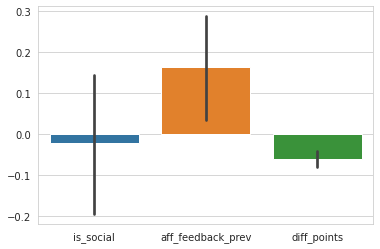

In [8]:
#run model on all subjects and plot, call dataset with regular expression
df = Dataset('data_csv/sub-10*.csv').get_model1_df()
sns.set_style("whitegrid")
print(df)
ax = sns.barplot(data=df)